<a href="https://colab.research.google.com/github/kimjaehwankimjaehwan/Dacon/blob/main/%EC%8B%A0%EC%95%BD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install rdkit-pypi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 47.4 MB/s eta 0:00:00


In [3]:
# 제 2회 신약 개발 AI 경진대회 Baseline
import pandas as pd
import numpy as np
import os
import random

from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error



In [4]:
CFG = {
    'NBITS':2048,
    'SEED':42,
}

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(CFG['SEED']) # Seed 고정

# SMILES 데이터를 분자 지문으로 변환
def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=CFG['NBITS'])
        return np.array(fp)
    else:
        return np.zeros((CFG['NBITS'],))



In [5]:
# 학습 ChEMBL 데이터 로드
chembl_data = pd.read_csv('/content/drive/MyDrive/데이콘/train.csv')  # 예시 파일 이름
chembl_data.head()

train = chembl_data[['Smiles', 'pIC50']]
train['Fingerprint'] = train['Smiles'].apply(smiles_to_fingerprint)

train_x = np.stack(train['Fingerprint'].values)
train_y = train['pIC50'].values



<ipython-input-5-41fabfe1763b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Fingerprint'] = train['Smiles'].apply(smiles_to_fingerprint)


In [6]:
# 학습 및 검증 데이터 분리
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.3, random_state=42)




In [ ]:
# from sklearn.model_selection import RandomizedSearchCV
# import numpy as np
# # 하이퍼 파라미터 그리드 설정
# params = {
#     'n_estimators': [int(x)for x in np.linspace(100,1000,10)],
#     'max_features': ['auto', 'sqrt'],  # 'max_feature'를 'max_features'로 수정
#     'max_depth': [int(x)for x in np.linspace(10,110,11)]+[None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False]
# }
# rfr = RandomForestRegressor(random_state=CFG['SEED'])
# rcv = RandomizedSearchCV(rfr, param_distributions=params, n_iter = 100, cv = 3, verbose = 2, random_state = 42, n_jobs = -1)
# rcv.fit(train_x, train_y)
# model = rcv.best_estimator_
# print(rcv.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
123 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
123 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/util

{'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': False}


In [ ]:

from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor # Use Regressor for continuous target

rf = RandomForestRegressor(n_jobs=-1, random_state=42) # Changed to Regressor
scores = cross_validate(rf, train_x, train_y, return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9499021545926372 0.6624274823949381


In [ ]:
rf.fit(train_x, train_y)
print(rf.feature_importances_)

[0.00000000e+00 9.94707443e-03 5.35362944e-04 ... 2.46440334e-05
 4.13348444e-04 1.27338114e-04]


In [ ]:
rf = RandomForestRegressor(oob_score=True, n_jobs=-1, random_state=42) # Use Regressor for continuous target
rf.fit(train_x, train_y)
print(rf.oob_score_)

0.6818740814553791


In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import ExtraTreesRegressor # Use Regressor for continuous target

et = ExtraTreesRegressor(n_jobs=-1, random_state=42) # Changed to Regressor
scores = cross_validate(et, train_x, train_y, return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9933664464493999 0.4148646544761031


In [ ]:
et.fit(train_x, train_y)
print(et.feature_importances_)

[6.59494635e-06 7.32781752e-04 3.63164498e-04 ... 1.04850125e-06
 1.35615113e-04 2.11134562e-06]


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(random_state=42)
scores = cross_validate(gb, train_x, train_y, return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.7748257336653344 0.6178010752523058


In [ ]:
gb = GradientBoostingRegressor(n_estimators=500, learning_rate=0.2, random_state=42) ## n_estimator로 트리의 갯수를 500개로 조정, learning_rate 기본값인 0.1에서 0.2로 변경
scores = cross_validate(gb, train_x, train_y, return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9620557053032698 0.6096310015553725


In [ ]:
gb.fit(train_x, train_y)
print(gb.feature_importances_)

[0.         0.01755002 0.00014498 ... 0.         0.         0.        ]


In [ ]:
## n_estimate의 갯수를 조절해서 모델의 훈련데이터의 score와 테스트데이터의 score를 시각화 하기
train_scores = []
test_scores = []
estimators = range(5, 500, 50)
for i in range(5, 500, 50):
    gb = GradientBoostingRegressor(n_estimators=i, random_state=42)
    scores = cross_validate(gb, train_x, train_y, return_train_score=True, n_jobs=-1)
    train_scores.append(np.mean(scores['train_score']))
    test_scores.append(np.mean(scores['test_score']))

In [ ]:
list(map(lambda x: print(f"Train Score: {x[0]}, Test Score: {x[1]}"), zip(train_scores, test_scores)))
# 테스트데이터 중 가장 높은 점수 고르고 해당 모델의 인덱스와 훈련데이터 점수, 테스트 데이터 점수를 표시하기
print(train_scores[test_scores.index(max(test_scores))], max(test_scores),  test_scores.index(max(test_scores)))
print(estimators[test_scores.index(max(test_scores))])

Train Score: 0.28344160675458097, Test Score: 0.24712255588728124
Train Score: 0.7054818452000896, Test Score: 0.5858900441450255
Train Score: 0.7798075069222135, Test Score: 0.619194825207307
Train Score: 0.8204493846235774, Test Score: 0.6273956854978759
Train Score: 0.8476601688820594, Test Score: 0.6328165744563774
Train Score: 0.8681044002648628, Test Score: 0.6346271258290676
Train Score: 0.8833955084253825, Test Score: 0.6327612500279713
Train Score: 0.8955614910755507, Test Score: 0.6326797954727228
Train Score: 0.9055013573588958, Test Score: 0.631372274809309
Train Score: 0.9143209072059972, Test Score: 0.6320524254331998
0.8681044002648628 0.6346271258290676 5
255


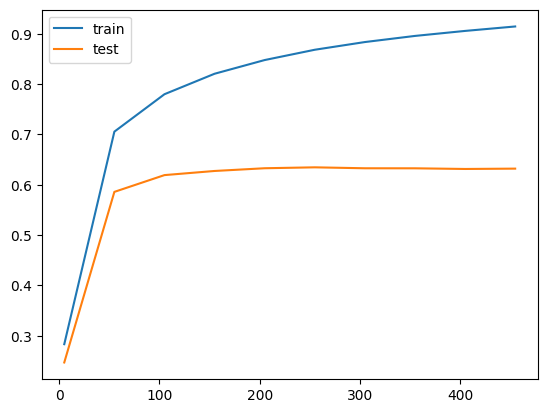

In [ ]:
import matplotlib.pyplot as plt
estimators = range(5, 500,50)
plt.plot(estimators, train_scores, label='train')
plt.plot(estimators, test_scores, label='test')
plt.legend()
plt.show()

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

hgb = HistGradientBoostingRegressor(random_state=42)
scores = cross_validate(hgb, train_x, train_y, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

/usr/local/lib/python3.10/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


0.9102382786667613 0.6452546763896557


In [ ]:
from sklearn.inspection import permutation_importance
hgb.fit(train_x, train_y)
result = permutation_importance(hgb, train_x, train_y, n_repeats=10, random_state=42, n_jobs=-1)

print(result.importances_mean)

[0.         0.00118886 0.00093299 ... 0.         0.         0.        ]


In [ ]:
result = permutation_importance(hgb, val_x, val_y, n_repeats=10, random_state=42, n_jobs=-1)
print(result.importances_mean)

[ 0.         -0.0006839   0.00170222 ...  0.          0.
  0.        ]


In [ ]:
hgb.score(val_x, val_y)

0.7044541638966003

In [ ]:
from xgboost import XGBRegressor

xgb = XGBRegressor(tree_method='hist', random_state=42)
scores = cross_validate(xgb, train_x, train_y, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9587643668454208 0.6304783536524574


In [ ]:
from lightgbm import LGBMRegressor

lgb = LGBMRegressor(random_state=42)
scores = cross_validate(lgb, train_x, train_y, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


0.9102382805837891 0.645254674945162


In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

base_estimator = DecisionTreeRegressor(max_depth=5, random_state=42)
ab = AdaBoostRegressor(base_estimator=base_estimator, n_estimators=50, random_state=42)
scores = cross_validate(ab, train_x, train_y, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.6821723210133637 0.56532972892432


In [ ]:
ab = AdaBoostRegressor(base_estimator=base_estimator, n_estimators=100, random_state=42)
scores = cross_validate(ab, train_x, train_y, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.671988160270061 0.5495487780183128


In [ ]:
ab.fit(train_x, train_y)
print(ab.feature_importances_)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[2.17208398e-05 2.87246805e-03 9.52647982e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


In [ ]:
## n_estimate의 갯수를 조절해서 모델의 훈련데이터의 score와 테스트데이터의 score를 시각화 하기
train_scores = []
test_scores = []
estimators = range(5, 500, 50)
for i in range(5, 500, 50):
    ab = AdaBoostRegressor(base_estimator=base_estimator, n_estimators=i, random_state=42)
    scores = cross_validate(ab, train_x, train_y, return_train_score=True, n_jobs=-1)
    train_scores.append(np.mean(scores['train_score']))
    test_scores.append(np.mean(scores['test_score']))

In [ ]:
list(map(lambda x: print(f"Train Score: {x[0]}, Test Score: {x[1]}"), zip(train_scores, test_scores)))
# 테스트데이터 중 가장 높은 점수 고르고 해당 모델의 인덱스와 훈련데이터 점수, 테스트 데이터 점수를 표시하기
print(train_scores[test_scores.index(max(test_scores))], max(test_scores),  test_scores.index(max(test_scores)))
print(estimators[test_scores.index(max(test_scores))])

Train Score: 0.6223712676515988, Test Score: 0.49313906538422375
Train Score: 0.6809019463942144, Test Score: 0.5638420354579902
Train Score: 0.6706158640282436, Test Score: 0.5487881097636527
Train Score: 0.6700495266129618, Test Score: 0.5474348351473095
Train Score: 0.6700056249016191, Test Score: 0.5426503401065718
Train Score: 0.673149813959643, Test Score: 0.5442187692553176
Train Score: 0.6721802932934766, Test Score: 0.5456543820141888
Train Score: 0.6727252689236101, Test Score: 0.5471188677254525
Train Score: 0.6732354828239104, Test Score: 0.5479910757779736
Train Score: 0.6722226919084464, Test Score: 0.5466164004934146
0.6809019463942144 0.5638420354579902 1
55


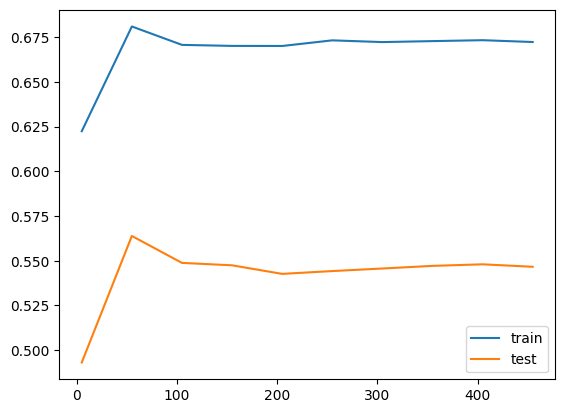

In [ ]:
import matplotlib.pyplot as plt
estimators = range(5, 500,50)
plt.plot(estimators, train_scores, label='train')
plt.plot(estimators, test_scores, label='test')
plt.legend()
plt.show()

In [8]:
from sklearn.svm import SVR
from sklearn.model_selection import cross_validate

svm = SVR(kernel='rbf', epsilon=1.0, gamma='scale')
scores = cross_validate(svm, train_x, train_y, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.6106682850762775 0.5064565885031356


In [ ]:
svm = SVR(kernel='rbf', epsilon=5.0, gamma='scale')
scores = cross_validate(svm, train_x, train_y, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

-0.003978325746963352 -0.008632853885280279


In [10]:
from sklearn.inspection import permutation_importance # Import the missing function
svm.fit(train_x, train_y)
result = permutation_importance(svm, train_x, train_y, n_repeats=10, random_state=42, n_jobs=-1)

print(result.importances_mean)

[ 9.07981670e-05  8.58213104e-03  2.40021071e-04 ... -1.92570225e-05
  4.48577045e-04 -7.19896457e-06]


In [11]:
result = permutation_importance(svm, val_x, val_y, n_repeats=10, random_state=42, n_jobs=-1)

print(result.importances_mean)

[ 7.57643021e-05  8.44370607e-03  4.51499496e-04 ... -1.04380504e-05
  1.60799073e-04 -9.53484982e-05]


In [12]:
svm.score(val_x, val_y)

0.542599237800569

In [ ]:
# # 랜덤 포레스트 모델 학습
# model = RandomForestRegressor(random_state=CFG['SEED'])
# model.fit(train_x, train_y)
# Assuming 'train_x' and 'train_y' are your training data
# gb.fit(train_x, train_y)
# xgb.fit(train_x, train_y)  # Train the model before making predictions
# lgb.fit(train_x, train_y)  # Fit the LGBMRegressor model
ab.fit(train_x, train_y)  # Train the AdaBoostRegressor model



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5,
                                                       random_state=42),
                  n_estimators=455, random_state=42)

In [13]:
def pIC50_to_IC50(pic50_values):
    """Convert pIC50 values to IC50 (nM)."""
    return 10 ** (9 - pic50_values)

In [14]:
# Validation 데이터로부터의 학습 모델 평가
val_y_pred = svm.predict(val_x)
mse = mean_squared_error(pIC50_to_IC50(val_y), pIC50_to_IC50(val_y_pred))
rmse = np.sqrt(mse)

print(f'RMSE: {rmse}')



RMSE: 2319.6558952908035


In [15]:
test = pd.read_csv('/content/drive/MyDrive/데이콘/test.csv')
test['Fingerprint'] = test['Smiles'].apply(smiles_to_fingerprint)

test_x = np.stack(test['Fingerprint'].values)

test_y_pred = svm.predict(test_x)

submit = pd.read_csv('/content/drive/MyDrive/데이콘/sample_submission.csv')
submit['IC50_nM'] = pIC50_to_IC50(test_y_pred)
submit.head()

submit.to_csv('./baseline_submit(svm2).csv', index=False)